# Tuning the hyperparameters for Random Forest Method!

In [5]:
import time
import os
import librosa
import numpy as np
import tensorflow

### SEED configuration
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

#!pip install keras-tuner  # en caso de necesitar instalarlo
#import keras_tuner as kt
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Loading the data 48KHz with 40 mel-spectrogram frequency bands

In [2]:
filename = '../processed_data/MFCCs_AUGMENTED_48.npy'
# open file in write mode and write data
with open(filename, 'rb') as f:
    F12 = np.load(f)
    F40 = np.load(f)
    Y = np.load(f)

In [3]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(F40,Y, test_size=0.1, random_state=42)

In [4]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [5]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_b, y_train_b)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [6]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

### Evaluation

In [12]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [8]:
# Baseline
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Base Accuracy
base_model.fit(X_train_b, y_train_b)
base_accuracy = evaluate(base_model, X_test_b, y_test_b)

# Best Model by Random Search
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_b, y_test_b)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.5694 degrees.
Accuracy = 84.32%.
Model Performance
Average Error: 0.1597 degrees.
Accuracy = 96.09%.
Improvement of 13.97%.


### GridSearch: Provided the best value from Random Search I specify a new grid, near the best results!.

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

In [9]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [20,22,24,26],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,3],
    'n_estimators': [1800,1820,1850,1900]
}

In [10]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [11]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(F40,Y, test_size=0.1, random_state=42)

In [12]:
# Fit the grid search to the data
grid_search.fit(X_train_b, y_train_b)
grid_search.best_params_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


{'bootstrap': False,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1820}

In [13]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1820}

In [14]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_b, y_test_b)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.1632 degrees.
Accuracy = 96.15%.
Improvement of 14.04%.


Los parámetros quedarán aquí guardados en forma de texto, para reentrenar el modelo basta simplemente usar ese grupo de parámetros. Y salvar el modelo utilizando las siguientes lineas!: 

In [15]:
#import joblib
## save
#joblib.dump(rf_random, "./random_forest.joblib")

## load, no need to initialize the loaded_rf
#loaded_rf = joblib.load("./random_forest.joblib")

In [21]:
from eval_classifiers import EvalBestModel
from eval_classifiers import EvalClassifiers

In [22]:
best_model = RandomForestClassifier(n_estimators = 1820, min_samples_split = 2, min_samples_leaf = 1, bootstrap = False)

In [23]:
best_model_results = EvalBestModel(best_model,X_train_b, y_train_b)

In [24]:
best_model_results 

,Best Model
0,0.992930
0,0.996403
0,0.994483
0,0.989458
0,0.985860
0,0.992620
0,0.994511
0,0.996377
0,0.998188
0,0.998214


In [25]:
best_model_results.describe()

,Best Model
count,10.000000
mean,0.993904
std,0.003902
min,0.985860
25%,0.992697
50%,0.994497
75%,0.996396
max,0.998214


In [ ]:
results_big_ensemble_48 = EvalClassifiers("big_ensemble_48", X_train_b, y_train_b, n_splits=10)

In [ ]:
results_big_ensemble_48

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
expert_final_1 = best_model_results["Best Model"]
expert_final_2 = results_big_ensemble_48

e_final_1 = np.reshape(np.asarray(expert_final_1),(10,1))
e_final_2 = np.reshape(np.asarray(expert_final_2),(10,3))

B = np.hstack((e_final_1 ,e_final_2))

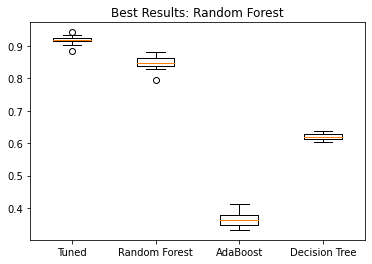

In [32]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best Results: Random Forest')
ax7.boxplot(B)
plt.xticks([1,2,3,4], ['Tuned', 'Random Forest','AdaBoost','Decision Tree'])
plt.show()

In [34]:
plt.savefig('best_results.png')

<Figure size 432x288 with 0 Axes>

### Final Tuning: using all the features!

Previous experiments demonstrate that using all the selected features (zero crossing, energy rms and spectral centroid) + mel-spectrogram averaged over the time with 40 bands, let us obtain the better results (over 95% of accuracy by using 10-fold cross validation)

In [6]:
filename = '../processed_data/ALL40_48.npy'
with open(filename, 'rb') as f:
    ALL40_48 = np.load(f)

In [7]:
filename = '../processed_data/ZE_48.npy'
# open file in write mode and write data
with open(filename, 'rb') as f:
    Z = np.load(f)
    E = np.load(f)
    Y = np.load(f)

In [8]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(ALL40_48, Y, test_size=0.10, random_state=42)

Following the same order: first a random search and finally a grid search near the best result!

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_b, y_train_b)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [13]:
# Baseline
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Base Accuracy
base_model.fit(X_train_b, y_train_b)
base_accuracy = evaluate(base_model, X_test_b, y_test_b)

# Best Model by Random Search
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_b, y_test_b)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.0851 degrees.
Accuracy = 97.81%.
Model Performance
Average Error: 0.0226 degrees.
Accuracy = 99.56%.
Improvement of 1.79%.


In [14]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=1400)

In [15]:
best_model_all_features = rf_random.best_estimator_

In [16]:
best_model_results_all_features = EvalBestModel(best_model_all_features,X_train_b, y_train_b)

In [17]:
best_model_results_all_features

,Best Model
0,0.992930
0,0.996403
0,0.996349
0,0.989458
0,0.989484
0,0.987336
0,0.994511
0,0.996377
0,0.998188
0,0.998214


In [18]:
best_model_results_all_features.describe()

,Best Model
count,10.000000
mean,0.993925
std,0.003930
min,0.987336
25%,0.990346
50%,0.995430
75%,0.996396
max,0.998214


Observando el resultado final!

In [ ]:
expert_final_3 = best_model_results_all_features["Best Model"]

e_final_3 = np.reshape(np.asarray(expert_final_3),(10,1))
B_final = np.hstack((B,e_final_3))

In [ ]:
fig8, ax8 = plt.subplots()
ax8.set_title('Best Results: Random Forest')
ax8.boxplot(B)
plt.xticks([1,2,3,4,5], ['Tuned-RF', 'RF','AdaBoost','DT','RF-All-Tuned'])
plt.show()

In [ ]:
plt.savefig('all_features.png')